At the moment, this project tries to assign scores based on the expected value of their 
hires given current estimates.

Because of the sampling issue it doesn't say much.  For example scores for tier 5 schools will be 
very low just because so few of the tier 5 schools hires were recorded.

Maybe it is best to be conditional on hiring, but not sure what that means.

In [1]:
using HTTP, JSON, PrettyTables, JLD, DotEnv, Distributions, LinearAlgebra, Dates, MySQL
cfg = DotEnv.config("../.env")
files_path = cfg["files_path"]
#adjacency = load(files_path*"placement_rates.jld")["placement_rates"]
classification_properties = load(files_path*"classification_properties.jld")["classification_properties"]
rep = JSON.parsefile(files_path*"likelihood_ratios.json");
refresh_mysql_db = true
classification_properties

Dict{String, Any} with 7 entries:
  "data_loaded"              => DateTime("2024-06-18T18:21:53.103")
  "row_labels"               => Any["TYPE 1 (20 insts)", "TYPE 2 (58 insts)", "…
  "unmatched_index"          => 10
  "number_of_academic_types" => 5
  "institution_counts"       => [20, 58, 180, 334, 522, 152, 227, 598, 413, 1, …
  "algorithm_run_id"         => 5
  "num_years"                => 24

In [2]:
function value_quantiles(a, value)
    # a is a vector of variable length, value is a real number
    # returns the proportion of values in the array that are less than or equal to value
    # dists[t][:,1] is the array of hire values for each member of tier t
    # dists[t][:,2] is the array of placement values for each member of tier t
       return length(a[a .<= value])/length(a)
end


value_quantiles (generic function with 1 method)

In [3]:
# creates an array conntaining matrices of different sizes
# dists[t][:,1] is an array of values of hires by each member of tier t
# dists[t][:,2] is an array of values of the placements of each member of the tier
dists = Array{Any}(nothing,5)
for k in 1:classification_properties["number_of_academic_types"]
    dist = zeros(classification_properties["institution_counts"][k],2)
    n = 1
    for r in rep
        if r["tier"]==k
            dist[n] = r["hiring_value"]
            dist[n+classification_properties["institution_counts"][k]] = r["placement_value"]
            n += 1
        end
    end
    dists[k] = dist
end

In [4]:
#length(a[a .< x])/length(a)
function distribution(a)
    b = Any[]
    for (index,value) in enumerate(a)
        push!(b,length(a[a .<= value])/length(a))
    end
    return b
end
            

distribution (generic function with 1 method)

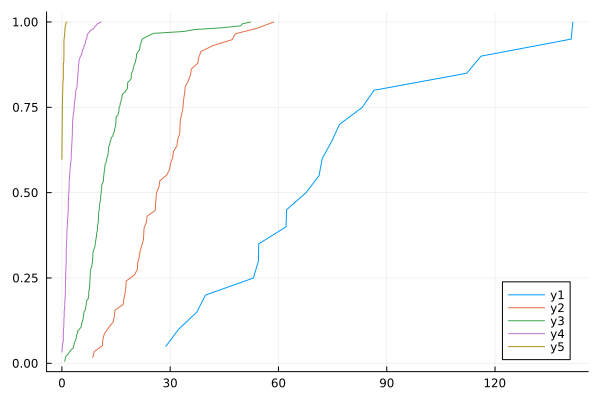

In [5]:
# display hiring values for each tier
using Plots
y = distribution(sort(dists[1][:,1]))
x = sort(dists[1][:,1])
plot(x,y)
y = distribution(sort(dists[2][:,1]))
x = sort(dists[2][:,1])
plot!(x,y)
y = distribution(sort(dists[3][:,1]))
x = sort(dists[3][:,1])
plot!(x,y)
y = distribution(sort(dists[4][:,1]))
x = sort(dists[4][:,1])
plot!(x,y)
y = distribution(sort(dists[5][:,1]))
x = sort(dists[5][:,1])
plot!(x,y)
            


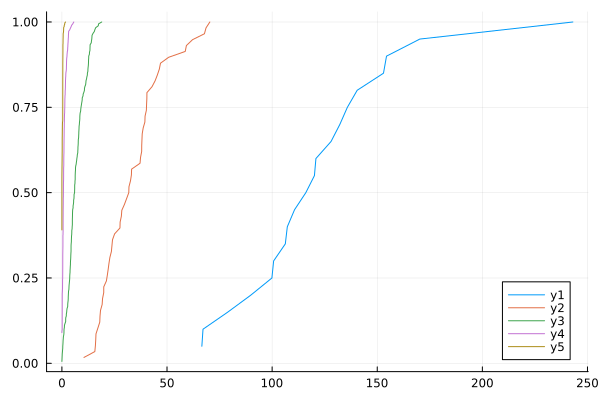

In [6]:
# display offer values for each tier
y = distribution(sort(dists[1][:,2]))
x = sort(dists[1][:,2])
plot(x,y)
y = distribution(sort(dists[2][:,2]))
x = sort(dists[2][:,2])
plot!(x,y)
y = distribution(sort(dists[3][:,2]))
x = sort(dists[3][:,2])
plot!(x,y)
y = distribution(sort(dists[4][:,2]))
x = sort(dists[4][:,2])
plot!(x,y)
y = distribution(sort(dists[5][:,2]))
x = sort(dists[5][:,2])
plot!(x,y)
  

In [7]:
refresh_mysql_db = false
if refresh_mysql_db == true
    d = DBInterface.connect(MySQL.Connection,cfg["host"], cfg["user"], cfg["password"], 
        db =cfg["database"], port = parse(Int64,cfg["port"]));
    q = """
    delete from t_distribution where algorithm_run_id=?
    """
    delete_statement = DBInterface.prepare(d, q)
    DBInterface.execute(delete_statement,[classification_properties["algorithm_run_id"]])
    
    query = """
        insert into econjobmarket_research.t_distribution (type,institution_id,created,algorithm_run_id, properties)
        values(?,?,?,?,?)
    """
    insert_statement =  DBInterface.prepare(d, query);
    function save_type(insert_statement,t,institution_id,run_id,json_data)
        #values would be the rep dict
        DBInterface.execute(insert_statement, [t,institution_id,now(),run_id,JSON.json(json_data)])
    end

end

In [8]:
new_rep = []
for r in rep
    r["placement_quantile"] = value_quantiles(dists[r["tier"]][:,2],r["placement_value"])
    r["hiring_quantile"] = value_quantiles(dists[r["tier"]][:,1], r["hiring_value"] )
    push!(new_rep, r)
    if refresh_mysql_db == true
        try
            save_type(insert_statement,r["tier"],parse(Int64,r["id"]),
            classification_properties["algorithm_run_id"],r)
        catch e
            rethrow(e)
        end
    end
end
open(files_path*"likelihood_ratios.json", "w") do f
    write(f, JSON.json(new_rep))
end
if refresh_mysql_db == true
    DBInterface.close!(d)
end


In [9]:
id = 57
for r in new_rep
    if r["id"] == string(id)
        for (key,value) in r
            println(key, " => ", value)
        end
    end
end

tier => 2
placement_ratios => Any[9.444293145204486e-47, 1.0, 2.3661427347761196e-35, 4.513195571063196e-110, 5.3192464947927263e-194]
hires => Any[34, 15, 11, 5, 0]
placement_value => 32.61420917644597
placement_quantile => 0.5344827586206896
name => University of British Columbia
euclidian => Any[84.93332679225512, 27.083885631125842, 49.88693636367227, 59.50640063126638, 61.40367557901417]
id => 57
hiring_quantile => 0.9655172413793104
hiring_ratios => Any[30.422132878859863, 1.0, 2.1548503530352365e-13, 1.0766144983816076e-52, 0.0]
ratios => Any[2.873155410103162e-45, 1.0, 5.0986835073640814e-48, 4.858971785838296e-162, 0.0]
placements => Any[3, 17, 35, 15, 0, 3, 4, 2, 0, 22, 0, 5]
hiring_value => 48.05680264249607


In [10]:
value_quantiles(dists[2][:,2], 33)

0.5344827586206896